<a href="https://colab.research.google.com/github/semmatoninn/PLGA-Microparticles-Drug-Release/blob/main/PLGAmicroparticle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Data Preparation

In [70]:
RANDOM_SEED = 1147

In [71]:
import pandas as pd
import numpy as np

!pip install rdkit
from rdkit import Chem # module chem
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem import PandasTools # module from rdkit.Chem

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    max_error
)

from sklearn.linear_model import LinearRegression

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV, KFold, GroupKFold, RandomizedSearchCV
from sklearn.kernel_ridge import KernelRidge

from xgboost import XGBRegressor

!pip install shap
import shap

In [72]:
!git clone https://github.com/semmatoninn/PLGA-Microparticles-Drug-Release.git
%cd PLGA-Microparticles-Drug-Release
import pandas as pd
df = pd.read_excel("mp_dataset_initial.xlsx")
df.head()


Cloning into 'PLGA-Microparticles-Drug-Release'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 51 (delta 21), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 4.33 MiB | 10.10 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/PLGA-Microparticles-Drug-Release/PLGA-Microparticles-Drug-Release


,Formulation Index,Drug,Drug SMILES,Polymer Mw,Polymer Mn,Polymer Molecular Weight,PDI,LA/GA,Formulation Method,Initial Drug-to-Polymer Ratio,Particle Size,Drug Loading Capacity,Drug Encapsulation Efficiency,Solubility Enhancer Concentration,Time,Release,DOI
0,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,0.000000,0.000000,10.3390/ijms241914729
1,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,1.889764,0.062622,10.3390/ijms241914729
2,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,7.181102,0.056751,10.3390/ijms241914729
3,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,13.984252,0.058708,10.3390/ijms241914729
4,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,27.968504,0.058708,10.3390/ijms241914729


In [73]:
df.shape

(4913, 17)

In [74]:
df.columns


Index(['Formulation Index', 'Drug', 'Drug SMILES', 'Polymer Mw ', 'Polymer Mn',
       'Polymer Molecular Weight', 'PDI', 'LA/GA', 'Formulation Method',
       'Initial Drug-to-Polymer Ratio', 'Particle Size ',
       'Drug Loading Capacity', 'Drug Encapsulation Efficiency',
       'Solubility Enhancer Concentration ', 'Time ', 'Release ', 'DOI'],
      dtype='object')

In [75]:
df.info() # 17 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4913 entries, 0 to 4912
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Formulation Index                   4913 non-null   int64  
 1   Drug                                4913 non-null   object 
 2   Drug SMILES                         4913 non-null   object 
 3   Polymer Mw                          2933 non-null   float64
 4   Polymer Mn                          291 non-null    float64
 5   Polymer Molecular Weight            1868 non-null   float64
 6   PDI                                 179 non-null    float64
 7   LA/GA                               4913 non-null   float64
 8   Formulation Method                  4913 non-null   object 
 9   Initial Drug-to-Polymer Ratio       4913 non-null   float64
 10  Particle Size                       4913 non-null   float64
 11  Drug Loading Capacity               4913 no

In [76]:
df.describe()

,Formulation Index,Polymer Mw,Polymer Mn,Polymer Molecular Weight,PDI,LA/GA,Initial Drug-to-Polymer Ratio,Particle Size,Drug Loading Capacity,Drug Encapsulation Efficiency,Solubility Enhancer Concentration,Time,Release
count,4913.000000,2933.000000,291.000000,1868.000000,179.000000,4913.000000,4913.000000,4913.000000,4913.000000,4913.000000,4913.000000,4913.000000,4913.000000
mean,159.926114,39.053910,23.696117,42.262141,1.694134,1.573165,0.254164,45.146116,12.880814,68.043714,1.004701,13.243417,0.525642
std,90.672849,28.783147,19.395257,32.187646,0.299379,0.978081,0.258735,45.053940,10.537514,21.832433,4.539232,17.634423,0.327611
min,1.000000,5.000000,2.300000,5.000000,1.300000,1.000000,0.000500,1.153000,0.022178,1.310000,0.000000,0.000000,0.000000
25%,85.000000,12.000000,6.100000,20.000000,1.300000,1.000000,0.100000,16.094710,4.800000,52.100000,0.000000,2.689872,0.218181
50%,152.000000,31.000000,10.000000,34.000000,1.710000,1.000000,0.200000,35.000000,9.320000,71.800000,0.000000,8.043956,0.571429
75%,241.000000,46.000000,32.000000,46.000000,1.960000,3.000000,0.250000,60.200000,17.982000,85.500000,0.100000,18.076366,0.824176
max,321.000000,104.000000,57.500000,215.000000,2.190000,5.670000,1.718876,295.700000,61.900000,100.000000,30.000000,237.732280,1.081614


In [77]:
df.head(10)

,Formulation Index,Drug,Drug SMILES,Polymer Mw,Polymer Mn,Polymer Molecular Weight,PDI,LA/GA,Formulation Method,Initial Drug-to-Polymer Ratio,Particle Size,Drug Loading Capacity,Drug Encapsulation Efficiency,Solubility Enhancer Concentration,Time,Release,DOI
0,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,0.000000,0.000000,10.3390/ijms241914729
1,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,1.889764,0.062622,10.3390/ijms241914729
2,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,7.181102,0.056751,10.3390/ijms241914729
3,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,13.984252,0.058708,10.3390/ijms241914729
4,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,27.968504,0.058708,10.3390/ijms241914729
5,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,48.755906,0.048924,10.3390/ijms241914729
6,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,62.740157,0.045010,10.3390/ijms241914729
7,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,69.543307,0.045010,10.3390/ijms241914729
8,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,76.724409,0.046967,10.3390/ijms241914729
9,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,107.716540,0.082192,10.3390/ijms241914729


**Dropping Source link Column - No predictive value**

In [78]:
df = df.drop(columns = 'DOI')
print(f"After dropping columns: the number of columns are {df.shape[1]}")

After dropping columns: the number of columns are 16


## **Null Values**

In [79]:
print(f"The number of nulls in df: {df.isna().sum().sum()}")

The number of nulls in df: 14381


In [80]:
df.isna().sum().sort_values(ascending=False)

,0
PDI,4734
Polymer Mn,4622
Polymer Molecular Weight,3045
Polymer Mw,1980
Drug SMILES,0
Drug,0
Formulation Index,0
LA/GA,0
Formulation Method,0
Initial Drug-to-Polymer Ratio,0


In [ ]:
# Drop columns with too many missing values - 4 columns dropped
df = df.drop(columns=['PDI', "Polymer Mn","Polymer Mw ","Polymer Molecular Weight"])
print(f"After dropping columns: the number of columns are {df.shape[1]}")

## Duplicates

In [81]:
print(f"Number of duplicated rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True) # dropping duplicates

Number of duplicated rows: 2


## **Zero variance columns**

In [82]:
zero_var_cols = df.columns[df.nunique() == 1].tolist()
print("Zero-variance columns:", zero_var_cols)


Zero-variance columns: []


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4911 entries, 0 to 4912
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Formulation Index                   4911 non-null   int64  
 1   Drug                                4911 non-null   object 
 2   Drug SMILES                         4911 non-null   object 
 3   Polymer Mw                          2932 non-null   float64
 4   Polymer Mn                          291 non-null    float64
 5   Polymer Molecular Weight            1867 non-null   float64
 6   PDI                                 179 non-null    float64
 7   LA/GA                               4911 non-null   float64
 8   Formulation Method                  4911 non-null   object 
 9   Initial Drug-to-Polymer Ratio       4911 non-null   float64
 10  Particle Size                       4911 non-null   float64
 11  Drug Loading Capacity               4911 non-nul

In [84]:
df.head(11)

,Formulation Index,Drug,Drug SMILES,Polymer Mw,Polymer Mn,Polymer Molecular Weight,PDI,LA/GA,Formulation Method,Initial Drug-to-Polymer Ratio,Particle Size,Drug Loading Capacity,Drug Encapsulation Efficiency,Solubility Enhancer Concentration,Time,Release
0,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,0.000000,0.000000
1,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,1.889764,0.062622
2,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,7.181102,0.056751
3,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,13.984252,0.058708
4,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,27.968504,0.058708
5,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,48.755906,0.048924
6,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,62.740157,0.045010
7,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,69.543307,0.045010
8,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,76.724409,0.046967
9,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,107.716540,0.082192


## **Canonicalization**

In [85]:
def canonicalize_smiles(smiles, isomeric:bool=True): # isomeric is flag/true or false, true is default
    """
    Convert any SMILES to its canonical form.

    Args:
        smiles (str): Input SMILES string

    Returns:
        str: Canonical SMILES
    """
    mol = Chem.MolFromSmiles(smiles) # creating mol object
    if mol is None:
        return None  # Invalid SMILES
    return Chem.MolToSmiles(mol, isomericSmiles=isomeric)

In [86]:
df['Drug canonical_smiles'] = df['Drug SMILES'].apply(canonicalize_smiles)

In [87]:
df.head()

,Formulation Index,Drug,Drug SMILES,Polymer Mw,Polymer Mn,Polymer Molecular Weight,PDI,LA/GA,Formulation Method,Initial Drug-to-Polymer Ratio,Particle Size,Drug Loading Capacity,Drug Encapsulation Efficiency,Solubility Enhancer Concentration,Time,Release,Drug canonical_smiles
0,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,0.000000,0.000000,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...
1,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,1.889764,0.062622,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...
2,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,7.181102,0.056751,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...
3,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,13.984252,0.058708,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...
4,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,27.968504,0.058708,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...


In [88]:
# Add a column called 'molecule' with mol objects
PandasTools.AddMoleculeColumnToFrame(df, # AddMoleculeColumnToFrame is a function inside PandasTools module
                                     smilesCol='Drug canonical_smiles', # input column
                                     molCol='Drug molecule' # output column - new column created
                                     ) # creates mol object from canonical smiles column

# df['molecule'] = df['canonical_smiles'].apply(Chem.MolFromSmiles) # the previous line is same as this
df.head()

,Formulation Index,Drug,Drug SMILES,Polymer Mw,Polymer Mn,Polymer Molecular Weight,PDI,LA/GA,Formulation Method,Initial Drug-to-Polymer Ratio,Particle Size,Drug Loading Capacity,Drug Encapsulation Efficiency,Solubility Enhancer Concentration,Time,Release,Drug canonical_smiles,Drug molecule
0,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,0.000000,0.000000,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7f508ca12340>
1,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,1.889764,0.062622,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7f508ca12960>
2,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,7.181102,0.056751,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7f508ca123b0>
3,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,13.984252,0.058708,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7f508ca12ea0>
4,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,27.968504,0.058708,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7f508ca12500>


In [89]:
# Define a function to calculate key molecular descriptors
def calculate_key_descriptors(mol):
    """Calculate key molecular descriptors for a molecule."""

    descriptors = {
        'Drug MW': Descriptors.MolWt(mol),
        'Drug LogP': Descriptors.MolLogP(mol), # Lipophilicity (octanol-water partition coefficient)
        'Drug TPSA': Descriptors.TPSA(mol), # Topological Polar Surface Area (important for drug absorption)
        # 'Drug HBD': Descriptors.NumHDonors(mol),
        # 'Drug HBA': Descriptors.NumHAcceptors(mol)
    }

    return descriptors

# Apply the function to the molecules in the DataFrame
descriptor_data = []
for idx, mol in df['Drug molecule'].items(): # index is row index, mol is molecule column value, molecule is mol object, it is pd series, index value pair
    desc = calculate_key_descriptors(mol) # dictionary created for each sample molecule
    descriptor_data.append(desc)

# Create descriptor DataFrame with pd.DataFrame()
# We use the same index as the original DataFrame to maintain row alignment
descriptor_df = pd.DataFrame(descriptor_data, index=df.index) # new dataframe created with descriptor columns

# Combine with the original molecules DataFrame
df_with_descriptors = pd.concat([df, descriptor_df], axis=1) # axis = 1, side by side concatenation

# Check the new dimensions - we should have the same number of rows but more columns
print(f"Dataset shape: {df_with_descriptors.shape}")
df_with_descriptors.head()

Dataset shape: (4911, 21)


,Formulation Index,Drug,Drug SMILES,Polymer Mw,Polymer Mn,Polymer Molecular Weight,PDI,LA/GA,Formulation Method,Initial Drug-to-Polymer Ratio,Particle Size,Drug Loading Capacity,Drug Encapsulation Efficiency,Solubility Enhancer Concentration,Time,Release,Drug canonical_smiles,Drug molecule,Drug MW,Drug LogP,Drug TPSA
0,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,0.000000,0.000000,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7f508ca12340>,639.83,5.7289,116.04
1,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,1.889764,0.062622,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7f508ca12960>,639.83,5.7289,116.04
2,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,7.181102,0.056751,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7f508ca123b0>,639.83,5.7289,116.04
3,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,13.984252,0.058708,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7f508ca12ea0>,639.83,5.7289,116.04
4,1,moxidectin,CC1CC(=CCC2CC(CC3(O2)CC(=NOC)C(C(O3)C(=CC(C)C)...,75.0,NaN,NaN,NaN,3.0,O/W,0.666667,47.723,35.41,88.3,0.5,27.968504,0.058708,CON=C1CC2(CC3CC(CC=C(C)CC(C)C=CC=C4COC5C(O)C(C...,<rdkit.Chem.rdchem.Mol object at 0x7f508ca12500>,639.83,5.7289,116.04


## Train test split

In [90]:
print(df.columns.tolist())


['Formulation Index', 'Drug', 'Drug SMILES', 'Polymer Mw ', 'Polymer Mn', 'Polymer Molecular Weight', 'PDI', 'LA/GA', 'Formulation Method', 'Initial Drug-to-Polymer Ratio', 'Particle Size ', 'Drug Loading Capacity', 'Drug Encapsulation Efficiency', 'Solubility Enhancer Concentration ', 'Time ', 'Release ', 'Drug canonical_smiles', 'Drug molecule']


In [91]:
# One-hot encode Formulation Method
TARGET = "Release "
df_encoded = pd.get_dummies(
    df_with_descriptors,
    columns=["Formulation Method"],
    drop_first=True
)

# Define FEATURES (exclude target + string/RDKit fields)
exclude_cols = [
    TARGET,
    "Drug",
    "Drug SMILES",
    "Drug canonical_smiles",
    "Drug molecule",
    "Formulation Index"
]

FEATURES = [col for col in df_encoded.columns if col not in exclude_cols]

# Group-aware train/test split (no leakage)
from sklearn.model_selection import GroupShuffleSplit

groups = df_encoded["Formulation Index"]

gss = GroupShuffleSplit(test_size=0.2, random_state=RANDOM_SEED)

train_idx, test_idx = next(gss.split(df_encoded, groups=groups))

#  Final datasets
X_train = df_encoded.iloc[train_idx][FEATURES]
X_test  = df_encoded.iloc[test_idx][FEATURES]

y_train = df_encoded.iloc[train_idx][TARGET]
y_test  = df_encoded.iloc[test_idx][TARGET]

# Looking at shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (3938, 17)
X_test: (973, 17)
y_train: (3938,)
y_test: (973,)


## Correlation analysis

### Pearson

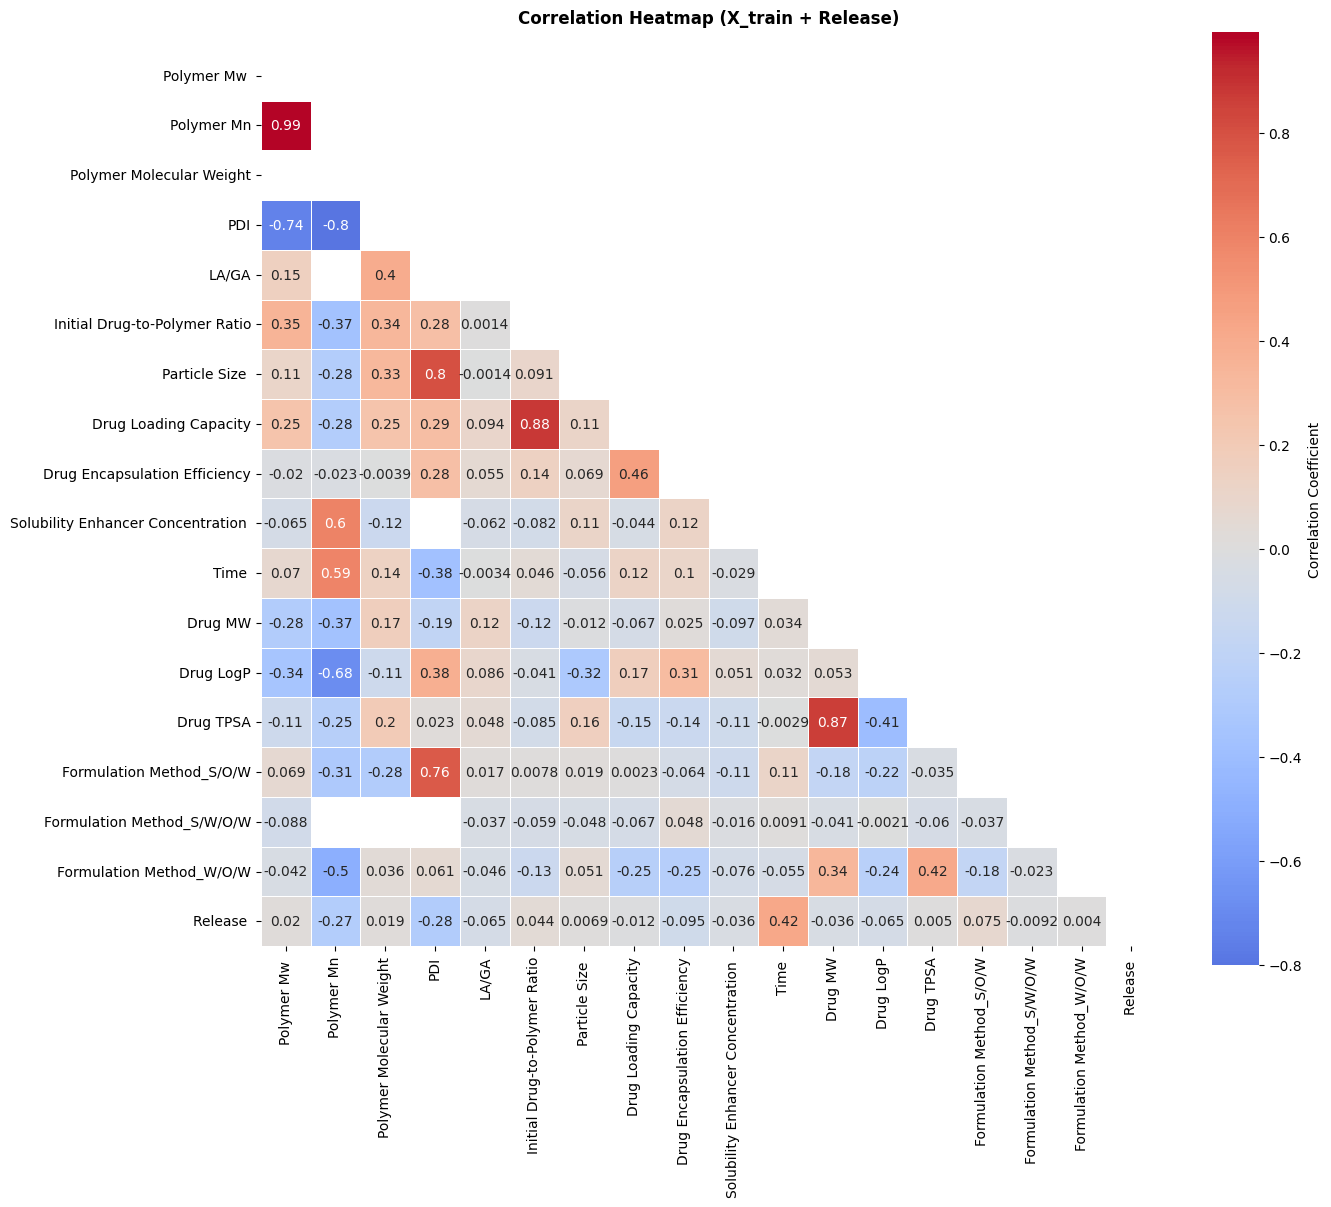

In [92]:
df_corr = X_train.copy()
df_corr["Release "] = y_train.values  # Add target column

# Compute correlation
corr_train = df_corr.corr(method="pearson")

plt.figure(figsize=(14, 12))

# Mask upper triangle for cleaner plot
mask = np.triu(np.ones_like(corr_train, dtype=bool))

sns.heatmap(
    corr_train,
    mask=mask,
    cmap='coolwarm',
    annot=True,   # Set True to show numbers
    center=0,
    square=True,
    linewidths=0.4,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title("Correlation Heatmap (X_train + Release)", fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In Pearson correlation - linear correlations are captured

Highest correlations between features are in

Drug loading capacity - Initial drug to polymer ratio 0.88

Drug TPSA and MW 0.87

Drug Encapsulation Efficiency and Drug Loading Capacity 0.46

Highest correlation with target variable release is time 0.42



### Spearman

In [ ]:

# Compute Spearman correlation
corr_train = df_corr.corr(method="spearman")

plt.figure(figsize=(14, 12))

# Mask upper triangle for cleaner plot
mask = np.triu(np.ones_like(corr_train, dtype=bool))

sns.heatmap(
    corr_train,
    mask=mask,
    cmap='coolwarm',
    annot=True,   # Set True to show numbers
    center=0,
    square=True,
    linewidths=0.4,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title("Correlation Heatmap (X_train + Release)", fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In Spearman correlations non-linear correlations are also captured, monotonic relationships are captured

Highest correlated features are

Drug loading capacity and initial drug to polymer ratio id 0.91

Drug TPSA and MW correlation is 0.62

Drug encapsulation efficiency and drug loading capacity correlation is 0.49

Drug LogP and Solubility Enhancer Concentration correlation is 0.43

Release and time correlation is 0.67


## Feature Outliers

In [ ]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(12, 6))
sns.boxplot(X_train[numeric_cols], orient='h')
# plt.tight_layout()
plt.savefig("outlier_detection.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
## regular split
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(
#    df[FEATURES], df[TARGET], test_size=0.2, random_state=RANDOM_SEED
#)

# II. Modelling

## Regression

In [ ]:

def get_regression_metrics(model, X, y_true):
    """
    Computes stable regression metrics for drug-release prediction.
    MAPE is intentionally excluded because y contains zeros - it explodes.
    """
    # Predictions
    y_pred = model.predict(X)

    # Core metrics
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mxe = max_error(y_true, y_pred)

    return {
        "r2": r2,
        "mse": mse,
        "mae": mae,
        "max_error": mxe
    }


### Linear Regression - Baseline

In [ ]:

linear_regressor = LinearRegression()

# Train the model on the training data
linear_regressor.fit(X_train,y_train)

linear_regressor_results_train = get_regression_metrics(linear_regressor,X_train,y_train )
linear_regressor_results_test = get_regression_metrics(linear_regressor, X_test,y_test )

# Print the results
print("Linear Regression Results - Train Set:", linear_regressor_results_train)
print("Linear Regression Results - Test Set:", linear_regressor_results_test)

### Linear Regression with Correlation based feature selection and scaler optimization








In [ ]:

# Correlation-based feature filter

class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.to_drop_ = None

    def fit(self, X, y=None):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)

        # Pearson absolute correlation
        corr = X_df.corr().abs()

        # Upper triangle (no diag)
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

        # Choose features to drop
        self.to_drop_ = [
            column
            for column in upper.columns
            if any(upper[column] > self.threshold)
        ]
        return self

    def transform(self, X):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        return X_df.drop(columns=self.to_drop_, errors="ignore")


#
# Pipeline: Corr Filter , Scaler , Linear Regression
#    (scaler will be chosen via GridSearch)

pipe = Pipeline([
    ("corr_filter", CorrelationFilter()),
    ("scaler", StandardScaler()),   # placeholder, will be overridden by param_grid
    ("model", LinearRegression())
])

#  Hyperparameter grid
#    correlation threshold
#    scaler type: Standard, MinMax, or no scaling

param_grid = {
    "corr_filter__threshold": [0.75, 0.8, 0.85, 0.9, 0.95],
    "scaler": [
        StandardScaler(),
        MinMaxScaler(),
        "passthrough"   # no scaling
    ]
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=1
)


#  Fit on training data
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

best_model = grid.best_estimator_

linear_corr_train = get_regression_metrics(best_model, X_train, y_train)
linear_corr_test  = get_regression_metrics(best_model, X_test, y_test)

print("Corr-Filtered + Scaler + Linear Regression - Train:", linear_corr_train)
print("Corr-Filtered + Scaler + Linear Regression - Test :", linear_corr_test)

best_filter = best_model.named_steps["corr_filter"]
print("Dropped features at best threshold:", best_filter.to_drop_)

print("Best scaler:", best_model.named_steps["scaler"])


Performance increased very slightly

### Linear Regression with Forward feature selection and scaler optimization



In [31]:
# Base estimator
base_model = LinearRegression()

# Function to generate a forward selector with a given number of features
def make_forward_selector(k):
    return SequentialFeatureSelector(
        estimator=base_model,
        n_features_to_select=k,
        direction="forward",
        scoring="r2",
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1
    )

pipe = Pipeline([
    ("scaler", StandardScaler()),      # placeholder (GridSearch will override)
    ("feature_select", make_forward_selector(5)),  # placeholder
    ("model", LinearRegression()),
])


param_grid = {
    "scaler": [
        StandardScaler(),
        MinMaxScaler(),
        "passthrough"              # no scaling
    ],
    "feature_select": [
        make_forward_selector(5),
        make_forward_selector(8),
        make_forward_selector(10),
        make_forward_selector(12)
    ],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the full optimized pipeline
grid.fit(X_train, y_train)

# Best model and parameters
print("Best Params:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

best_model = grid.best_estimator_


train_metrics = get_regression_metrics(best_model, X_train, y_train)
test_metrics  = get_regression_metrics(best_model, X_test, y_test)

print("\nOptimized Forward Selection + Scaler Pipeline")
print("Train:", train_metrics)
print("Test :", test_metrics)


sfs = best_model.named_steps["feature_select"]
selected_features = X_train.columns[sfs.get_support()]

print("\nSelected features:")
for f in selected_features:
    print("  -", f)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {'feature_select': SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                          estimator=LinearRegression(), n_features_to_select=5,
                          n_jobs=-1, scoring='r2'), 'scaler': 'passthrough'}
Best CV R²: 0.13003232202846876

Optimized Forward Selection + Scaler Pipeline
Train: {'r2': 0.2047678245599499, 'mse': 0.08626095051015835, 'mae': 0.2557851207137815, 'max_error': np.float64(1.4272087992064821)}
Test : {'r2': 0.19417005566465595, 'mse': 0.08248787598567496, 'mae': 0.24487135851560762, 'max_error': np.float64(0.7791327988789685)}

Selected features:
  - LA/GA
  - Particle Size 
  - Drug Encapsulation Efficiency
  - Time 
  - Drug MW


Did not perform better

##KRR

In [32]:

krr = KernelRidge(kernel='rbf') # without regularization and no scaling
krr.fit(X_train,y_train)
# get the metrics on the train and the test set using the get_regression_metrics functions (as above)
krr_results_train = get_regression_metrics(krr, X_train,y_train )
krr_results_test = get_regression_metrics(krr, X_test,y_test )


# the results
print("KRR Results - Train Set:", krr_results_train)
print("KRR Results - Test Set:", krr_results_test)

KRR Results - Train Set: {'r2': 0.7101790287931267, 'mse': 0.03143765207971872, 'mae': 0.1326728839838542, 'max_error': np.float64(0.5846759478749965)}
KRR Results - Test Set: {'r2': -2.1269108859473125, 'mse': 0.3200827162001578, 'mae': 0.46817671290483803, 'max_error': np.float64(1.0739394)}


without regularization, KRR usually overfits, shown here as well

In [33]:
pipe_w_scaling = Pipeline(
   [
       ('scaling', StandardScaler()),
       ('krr', KernelRidge(kernel="rbf"))
   ]
)
pipe_w_scaling.fit(X_train,y_train)

pipeline_results_train = get_regression_metrics(pipe_w_scaling, X_train, y_train )
pipeline_results_test = get_regression_metrics(pipe_w_scaling, X_test,y_test )


# # Print the results
print("Pipeline Results - Train Set:", pipeline_results_train)
print("Pipeline Results - Test Set:", pipeline_results_test)

Pipeline Results - Train Set: {'r2': 0.6712383232737087, 'mse': 0.03566165404465731, 'mae': 0.1476806376845786, 'max_error': np.float64(0.7616726730102693)}
Pipeline Results - Test Set: {'r2': 0.39112193496695136, 'mse': 0.062327118360276296, 'mae': 0.18726731076360176, 'max_error': np.float64(1.071669242591635)}


In [34]:
print(pipe_w_scaling.named_steps["krr"].get_params())

{'alpha': 1, 'coef0': 1, 'degree': 3, 'gamma': None, 'kernel': 'rbf', 'kernel_params': None}


Mild overfitting for standardized default krr model

### KRR with Regularization and Hyperparameter Tuning

In [35]:


# possible scalers
scalers = [StandardScaler(), MinMaxScaler(), "passthrough"]

pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('krr', KernelRidge(kernel='rbf'))
])

param_grid = [
    {
        'scaling': scalers,
        'krr__alpha': [0.001, 0.01, 0.1, 1],
        'krr__gamma': np.logspace(-3, 1, 20)
    }
]

# Grid search with 5-fold CV
search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

search.fit(X_train, y_train)

# Print best result
print("Best Params:", search.best_params_)
print("Best CV R²:", search.best_score_)


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Params: {'krr__alpha': 1, 'krr__gamma': np.float64(0.0069519279617756054), 'scaling': StandardScaler()}
Best CV R²: 0.2495171169101301


In [36]:
X_train.columns

Index(['LA/GA', 'Initial Drug-to-Polymer Ratio', 'Particle Size ',
       'Drug Loading Capacity', 'Drug Encapsulation Efficiency',
       'Solubility Enhancer Concentration ', 'Time ', 'Drug MW', 'Drug LogP',
       'Drug TPSA', 'Formulation Method_S/O/W', 'Formulation Method_S/W/O/W',
       'Formulation Method_W/O/W'],
      dtype='object')

In [37]:
best_krr = search.best_estimator_
best_krr.fit(X_train, y_train)

train_results = get_regression_metrics(best_krr, X_train, y_train)
test_results  = get_regression_metrics(best_krr, X_test,  y_test)

print("Tuned KRR - Train:", train_results)
print("Tuned KRR - Test :", test_results)


Tuned KRR - Train: {'r2': 0.437963377400725, 'mse': 0.060965608264158436, 'mae': 0.20959670512663695, 'max_error': np.float64(0.9104324332251363)}
Tuned KRR - Test : {'r2': 0.2811688736732765, 'mse': 0.07358233982231668, 'mae': 0.2134931362295479, 'max_error': np.float64(1.088611834250323)}


better than linear regression models

In [38]:
# group aware cross validation

# groups for TRAIN SET (must align with X_train)
groups_train = df_encoded.iloc[train_idx]["Formulation Index"].values

# Define pipeline placeholder (scaler will be set dynamically)
pipe = Pipeline([
    ('scaling', StandardScaler()),  # dummy; will be overridden in param_grid
    ('krr', KernelRidge(kernel='rbf'))
])

# Define parameter grid
param_grid = {
    'scaling': scalers,
    'krr__alpha': [0.001, 0.01, 0.1, 1],
    'krr__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

# Group-aware CV instead of plain cv=5
cv = GroupKFold(n_splits=5)

# Grid search with group-aware CV
search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

search.fit(X_train, y_train, groups=groups_train)

print("Best Params:", search.best_params_)
print("Best CV R²:", search.best_score_)

best_krr = search.best_estimator_
best_krr.fit(X_train, y_train)

train_results = get_regression_metrics(best_krr, X_train, y_train)
test_results  = get_regression_metrics(best_krr, X_test,  y_test)

print("Tuned KRR - Train:", train_results)
print("Tuned KRR - Test :", test_results)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Params: {'krr__alpha': 1, 'krr__gamma': 0.1, 'scaling': StandardScaler()}
Best CV R²: 0.38707408462817644
Tuned KRR - Train: {'r2': 0.6956118480223927, 'mse': 0.033017792947184835, 'mae': 0.14105625983074885, 'max_error': np.float64(0.7710787411772846)}
Tuned KRR - Test : {'r2': 0.44546279010512657, 'mse': 0.05676457783779608, 'mae': 0.183754296023381, 'max_error': np.float64(0.9458484998004952)}


## XGBoost

In [39]:
# XGBoost expects floats
X_tr = X_train.to_numpy(dtype=float)
y_tr = y_train.to_numpy(dtype=float)
X_te = X_test.to_numpy(dtype=float)
y_te = y_test.to_numpy(dtype=float)



xgb = XGBRegressor(
    n_estimators=1200,        # number of trees
    learning_rate=0.04,       # how much each tree contributes
    # max_depth=5,              # trees depth
    # min_child_weight=12,      # larger leaves (regularization)
    gamma=0.6,                # split penalty
    # subsample=0.7,            # row sampling
    # colsample_bytree=0.6,     # feature sampling
    reg_alpha=1.0,            # L1
    reg_lambda=6.0,           # L2
    objective="reg:squarederror",
    tree_method="hist",
    n_jobs=4,
    random_state=1147,
    verbosity=0,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb.fit(X_tr, y_tr)

print("XGBoost Results - Train Set:", get_regression_metrics(xgb, X_tr, y_tr))
print("XGBoost Results - Test Set:",  get_regression_metrics(xgb, X_te, y_te))

XGBoost Results - Train Set: {'r2': 0.7188346759574096, 'mse': 0.030498750995568747, 'mae': 0.13817477527760846, 'max_error': np.float64(0.726655842078064)}
XGBoost Results - Test Set: {'r2': 0.6002592072909755, 'mse': 0.04091901668235285, 'mae': 0.15619917499409838, 'max_error': np.float64(0.6848861684899903)}


Xgboost performance shows that this is a difficult task to predict

### Hypertune XGBOOST

In [40]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import GroupKFold, RandomizedSearchCV  # or GridSearchCV
# from sklearn.metrics import make_scorer, r2_score


groups_train = df_encoded.iloc[train_idx]["Formulation Index"].values

print("Unique formulation groups in train:", np.unique(groups_train).shape[0])

xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=RANDOM_SEED,
    n_jobs=-1
)

param_distributions = {
    "n_estimators": [300, 500, 800, 1200],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 10],
    "gamma": [0, 0.1, 0.3, 0.5],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [0.1, 1, 5, 10],
}

# 4) Group-aware CV
cv = GroupKFold(n_splits=5)

# 5) RandomizedSearchCV (you can swap to GridSearchCV if you prefer)
search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=50,              # adjust depending on time
    scoring="r2",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_SEED
)

search_xgb.fit(X_train, y_train, groups=groups_train)

print("Best XGB Params:", search_xgb.best_params_)
print("Best XGB CV R²:", search_xgb.best_score_)

best_xgb = search_xgb.best_estimator_


xgb_train_results = get_regression_metrics(best_xgb, X_train, y_train)
xgb_test_results  = get_regression_metrics(best_xgb, X_test,  y_test)

print("Tuned Group-Aware XGB - Train:", xgb_train_results)
print("Tuned Group-Aware XGB - Test :", xgb_test_results)


Unique formulation groups in train: 256
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGB Params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.6}
Best XGB CV R²: 0.6034322129946711
Tuned Group-Aware XGB - Train: {'r2': 0.8301984056786269, 'mse': 0.01841883084798064, 'mae': 0.105255906038382, 'max_error': np.float64(0.6917541039112549)}
Tuned Group-Aware XGB - Test : {'r2': 0.6094680255612569, 'mse': 0.03997636635669372, 'mae': 0.14950207097471957, 'max_error': np.float64(0.704871204786377)}


Best model so far

# III. Model Interpretation and Explainability

## PFI

In [41]:
def get_perm_importance(model, X, y, features, n=10):
    """
    Calculate permutation importance score for each feature
    """
    # Calculate baseline score (without permuting any feature)

    baseline_score = model.score(X, y)

    importance_scores = {}

    # Loop over each feature
    for feature in features:
        X_perm = X.copy()
        sum_score = 0

        # Repeat n times to get average importance score
        for i in range(n):
            # Calculate score when given feature is permuted
            X_perm[feature] = np.random.permutation(X_perm[feature].values)
            permuted_score = model.score(X_perm, y)

            sum_score += permuted_score

        # Calculate decrease in score
        importance_score = baseline_score - (sum_score / n)
        importance_scores[feature] = importance_score

    return importance_scores

Calculating permutation importance for best_xgb...

--- Top 10 Permutation Feature Importance (best_xgb, Time Excluded) ---
Drug Encapsulation Efficiency: 0.03338
Drug TPSA: 0.01380
Initial Drug-to-Polymer Ratio: 0.00967
Particle Size : 0.00950
Drug MW: 0.00860
Drug LogP: 0.00821
Formulation Method_S/O/W: 0.00654
LA/GA: 0.00503
Drug Loading Capacity: 0.00277
Formulation Method_S/W/O/W: 0.00000


/tmp/ipython-input-474/836049662.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


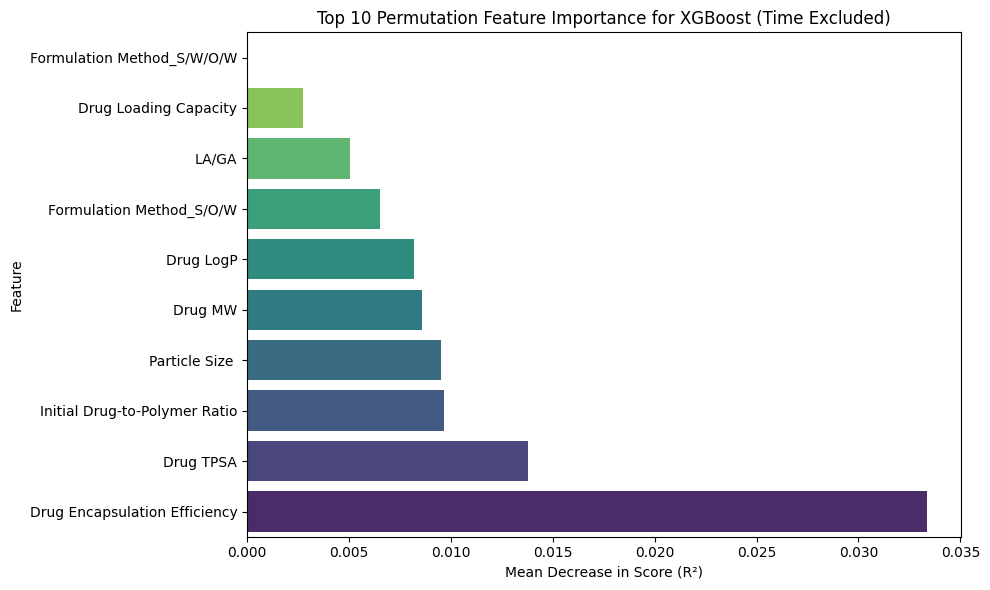

In [42]:

features_no_time = [f for f in X_test.columns if "time" not in f.lower()]

# Compute PFI for best_xgb

print("Calculating permutation importance for best_xgb...")

xgb_perm_importance = get_perm_importance(
    best_xgb,
    X_test,
    y_test,
    features_no_time        # time excluded
)

#  Sort and get top 10 features
sorted_xgb_importance = sorted(
    xgb_perm_importance.items(),
    key=lambda item: item[1],
    reverse=True
)

top_10_xgb_features = [item[0] for item in sorted_xgb_importance[:10]]
top_10_xgb_values   = [item[1] for item in sorted_xgb_importance[:10]]

print("\n--- Top 10 Permutation Feature Importance (best_xgb, Time Excluded) ---")
for f, v in zip(top_10_xgb_features, top_10_xgb_values):
    print(f"{f}: {v:.5f}")


#  Plotting top 10 PFI
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_10_xgb_values,
    y=top_10_xgb_features,
    palette='viridis'
)
plt.xlabel('Mean Decrease in Score (R²)')
plt.ylabel('Feature')
plt.title('Top 10 Permutation Feature Importance for XGBoost (Time Excluded)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## XGBOOST with PFI Feature Selection

In [43]:

# Sort PFI results (highest to lowest)
sorted_importance = sorted(
    xgb_perm_importance.items(),
    key=lambda x: x[1],
    reverse=True
)

# Select Top-10 from PFI
top_10_pfi_features = [feat for feat, score in sorted_importance[:10]]

# Automatically detect REAL time feature
time_cols = [c for c in X_train.columns if "time" in c.lower()]
if len(time_cols) == 0:
    raise ValueError("No time column found in X_train!")
time_col = time_cols[0]

# Add it if missing
if time_col not in top_10_pfi_features:
    top_10_pfi_features.append(time_col)

print("\nSelected features for final model (Top-10 PFI + Time):")
for f in top_10_pfi_features:
    print("  -", f)

# Subset train/test to these features
X_train_top10 = X_train[top_10_pfi_features].copy()
X_test_top10  = X_test[top_10_pfi_features].copy()

#Final XGBoost (using best hyperparameters)
final_xgb_top10 = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=RANDOM_SEED,
    n_jobs=-1,
    subsample=0.8,
    reg_lambda=0.1,
    reg_alpha=0,
    n_estimators=300,
    min_child_weight=1,
    max_depth=6,
    learning_rate=0.03,
    gamma=0.3,
    colsample_bytree=0.6
)

final_xgb_top10.fit(X_train_top10, y_train)

# Evaluate final model
train_top10_metrics = get_regression_metrics(final_xgb_top10, X_train_top10, y_train)
test_top10_metrics  = get_regression_metrics(final_xgb_top10, X_test_top10,  y_test)

print("\nFinal XGB (Top-10 PFI + Time) - Train:", train_top10_metrics)
print("Final XGB (Top-10 PFI + Time) - Test :", test_top10_metrics)



Selected features for final model (Top-10 PFI + Time):
  - Drug Encapsulation Efficiency
  - Drug TPSA
  - Initial Drug-to-Polymer Ratio
  - Particle Size 
  - Drug MW
  - Drug LogP
  - Formulation Method_S/O/W
  - LA/GA
  - Drug Loading Capacity
  - Formulation Method_S/W/O/W
  - Time 

Final XGB (Top-10 PFI + Time) - Train: {'r2': 0.8279478231453985, 'mse': 0.0186629575250865, 'mae': 0.10593543761687123, 'max_error': np.float64(0.6767589461925965)}
Final XGB (Top-10 PFI + Time) - Test : {'r2': 0.6264101658525749, 'mse': 0.03824210321953166, 'mae': 0.14741904891702048, 'max_error': np.float64(0.6989164462190247)}


## SHAP Analysis

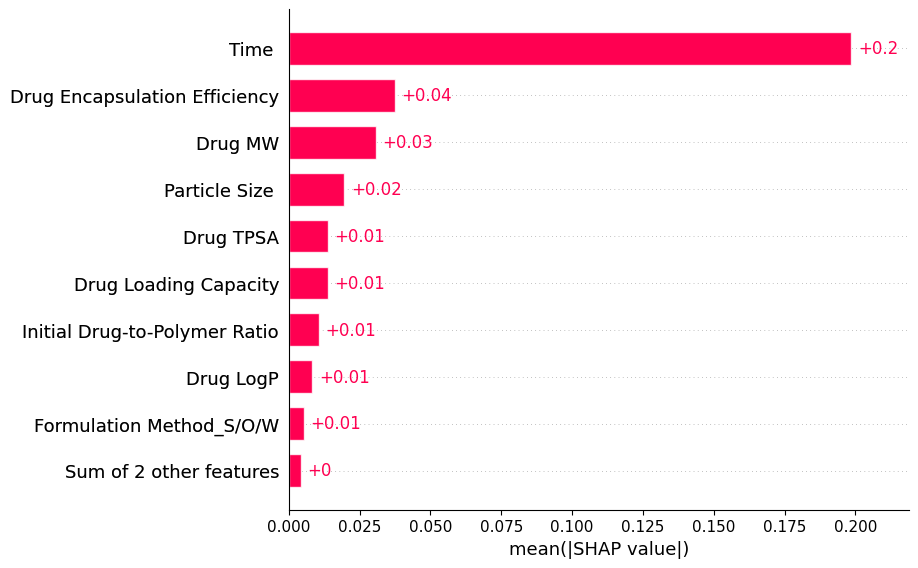

In [44]:
import numpy as np
import shap

#Original SHAP values
explainer = shap.TreeExplainer(final_xgb_top10)
shap_values = explainer(X_train_top10)
shap.plots.bar(shap_values)


## Beeswarm Plot

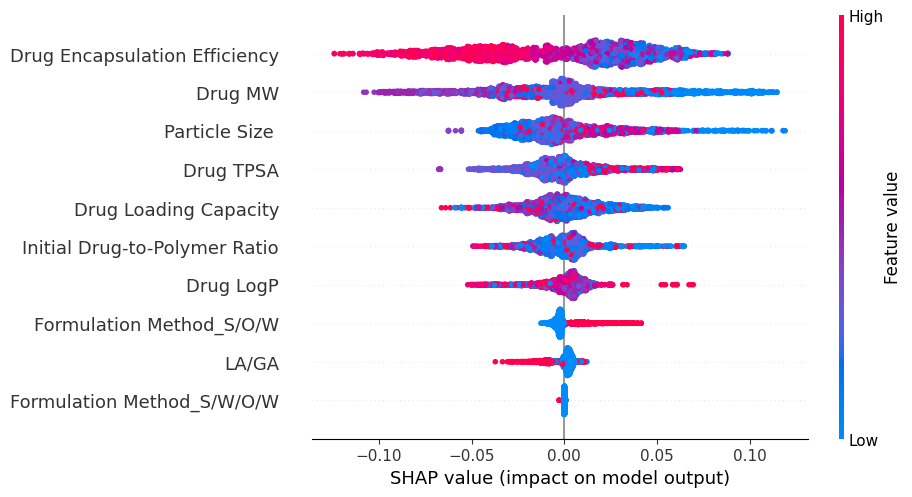

In [45]:
import numpy as np
import shap

#Original SHAP values
explainer = shap.TreeExplainer(final_xgb_top10)
shap_values = explainer(X_train_top10)

#Find the time column and its index
time_cols = [c for c in X_train_top10.columns if "time" in c.lower()]
time_col = time_cols[0]          # assume only one time column
time_idx = list(X_train_top10.columns).index(time_col)

#Build a mask that EXCLUDES the time column
mask = np.array([i != time_idx for i in range(len(X_train_top10.columns))])

#Create a new SHAP Explanation without time
shap_values_no_time = shap.Explanation(
    values       = shap_values.values[:, mask],
    base_values  = shap_values.base_values,
    data         = shap_values.data[:, mask],
    feature_names=[name for i, name in enumerate(shap_values.feature_names) if i != time_idx]
)

#Beeswarm plot WITHOUT time
shap.plots.beeswarm(shap_values_no_time)


#IV. Predicted vs Actual Drug release


Selected unseen formulations: [264, 123, 152, 81]


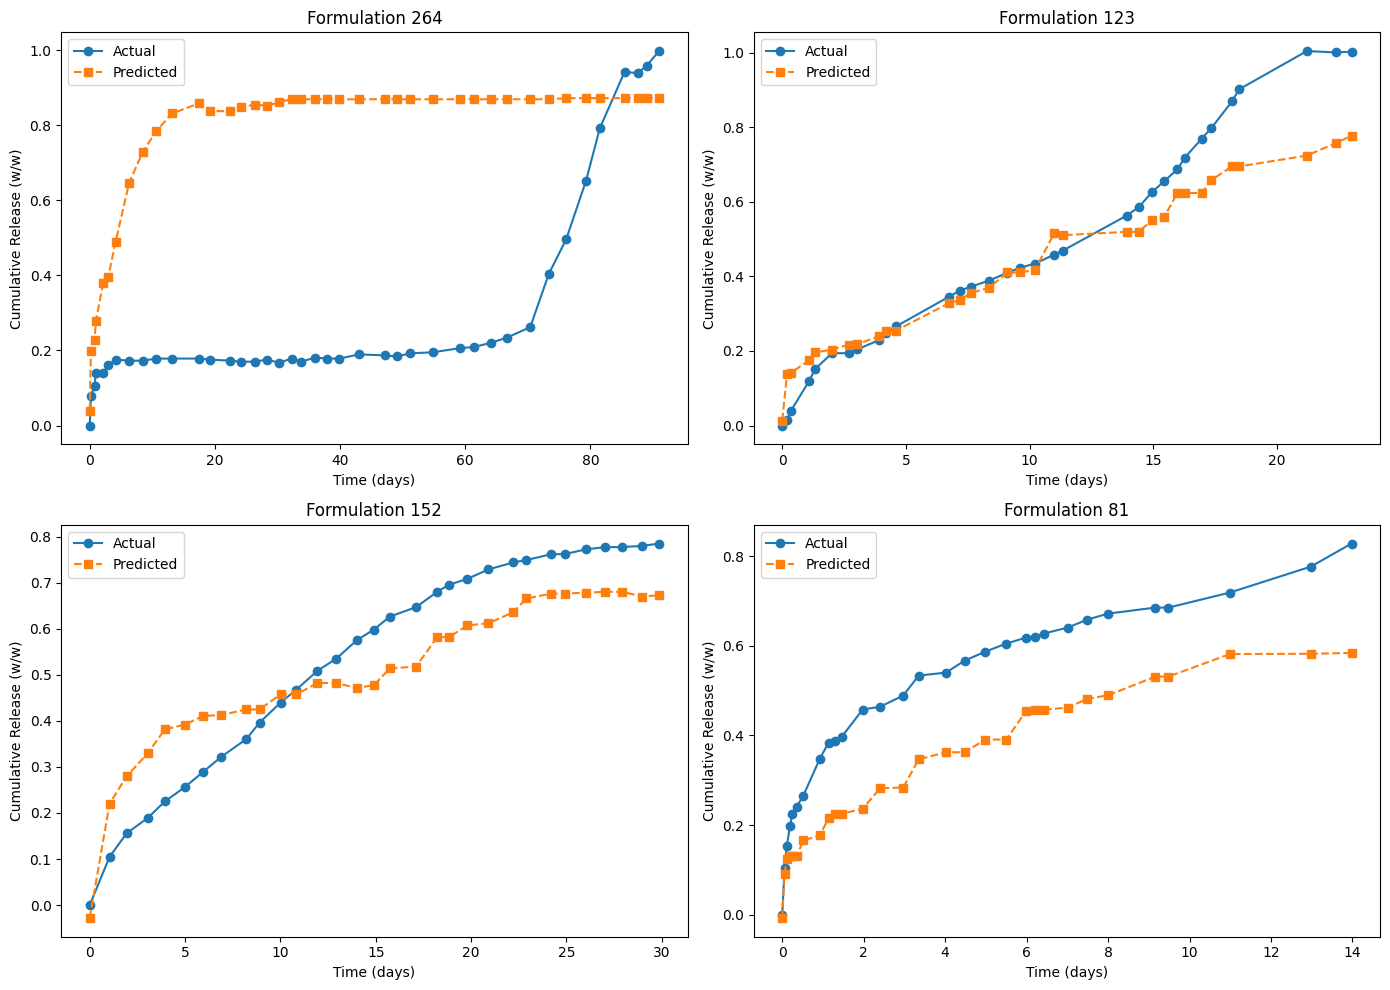

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# TEST portion of the original dataset ---
test_df = df_with_descriptors.iloc[test_idx].copy()

# Identify formulations present in the test set
forms_in_test = test_df["Formulation Index"].unique()

# Choose 4 representative formulations
form_sizes = test_df["Formulation Index"].value_counts()
chosen_forms = form_sizes.index[:4].tolist()

print("Selected unseen formulations:", chosen_forms)

#plot setup
plt.figure(figsize=(14, 10))

time_col = "Time "       # adjust if you stripped spaces
release_col = "Release " # adjust if you stripped spaces

for i, form in enumerate(chosen_forms, 1):

    # subset data for this formulation
    sub_df = test_df[test_df["Formulation Index"] == form].copy()

    # ensure time order
    sub_df = sub_df.sort_values(by=time_col)

    # slice matching rows from X_test
    X_sub = X_test.loc[sub_df.index, top_10_pfi_features]

    # predictions
    sub_df["Release_pred"] = final_xgb_top10.predict(X_sub)

    # --- 3. Plot each formulation ---
    plt.subplot(2, 2, i)

    plt.plot(sub_df[time_col], sub_df[release_col], "o-", label="Actual")
    plt.plot(sub_df[time_col], sub_df["Release_pred"], "s--", label="Predicted")

    plt.title(f"Formulation {form}")
    plt.xlabel("Time (days)")
    plt.ylabel("Cumulative Release (w/w)")
    plt.legend()

plt.tight_layout()
plt.show()


In [47]:
df[df["Formulation Index"] == 123][["Drug"]]

,Drug
1833,dexamethasone
1834,dexamethasone
1835,dexamethasone
1836,dexamethasone
1837,dexamethasone
1838,dexamethasone
1839,dexamethasone
1840,dexamethasone
1841,dexamethasone
1842,dexamethasone


#V. Drug descriptor and Clustering


In [48]:
df_with_descriptors
import pandas as pd

drug_descriptor_cols = [
    "Drug MW",
    "Drug TPSA",
    "Drug LogP",
    # "Drug pKa"   # uncomment if exists
]

# One row per drug
drug_df = (
    df_with_descriptors
    .groupby("Drug")[drug_descriptor_cols]
    .mean()        # descriptors should be constant, mean is safe
    .reset_index()
)

print(drug_df.head())
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_drug = scaler.fit_transform(drug_df[drug_descriptor_cols])

                  Drug  Drug MW  Drug TPSA  Drug LogP
0  2-methoxyestradiol   302.414      49.69     3.6178
1  4-methoxy chalcone   238.286      26.30     3.5913
2       5-fluorouracil  130.078      65.72    -0.7977
3         ?-methasone   392.467      94.83     1.8957
4              ABT627   510.631      88.54     4.6940


In [49]:
import umap

umap_model = umap.UMAP(
    n_neighbors=5,
    min_dist=0.3,
    n_components=2,
    random_state=1147
)

drug_embedding = umap_model.fit_transform(X_drug)

drug_df["UMAP1"] = drug_embedding[:,0]
drug_df["UMAP2"] = drug_embedding[:,1]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [50]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3,
    metric="euclidean"
)

drug_df["Cluster"] = clusterer.fit_predict(drug_embedding)

print(drug_df[["Drug","Cluster"]])

                              Drug  Cluster
0              2-methoxyestradiol         0
1              4-methoxy chalcone         0
2                   5-fluorouracil        0
3                     ?-methasone         0
4                          ABT627         0
..                             ...      ...
84  tenofovir alafenamide fumarate        2
85     thioridazine hydrochloride         0
86                    trimethoprim        0
87                     triptolide         0
88                      vancomycin        1

[89 rows x 2 columns]


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


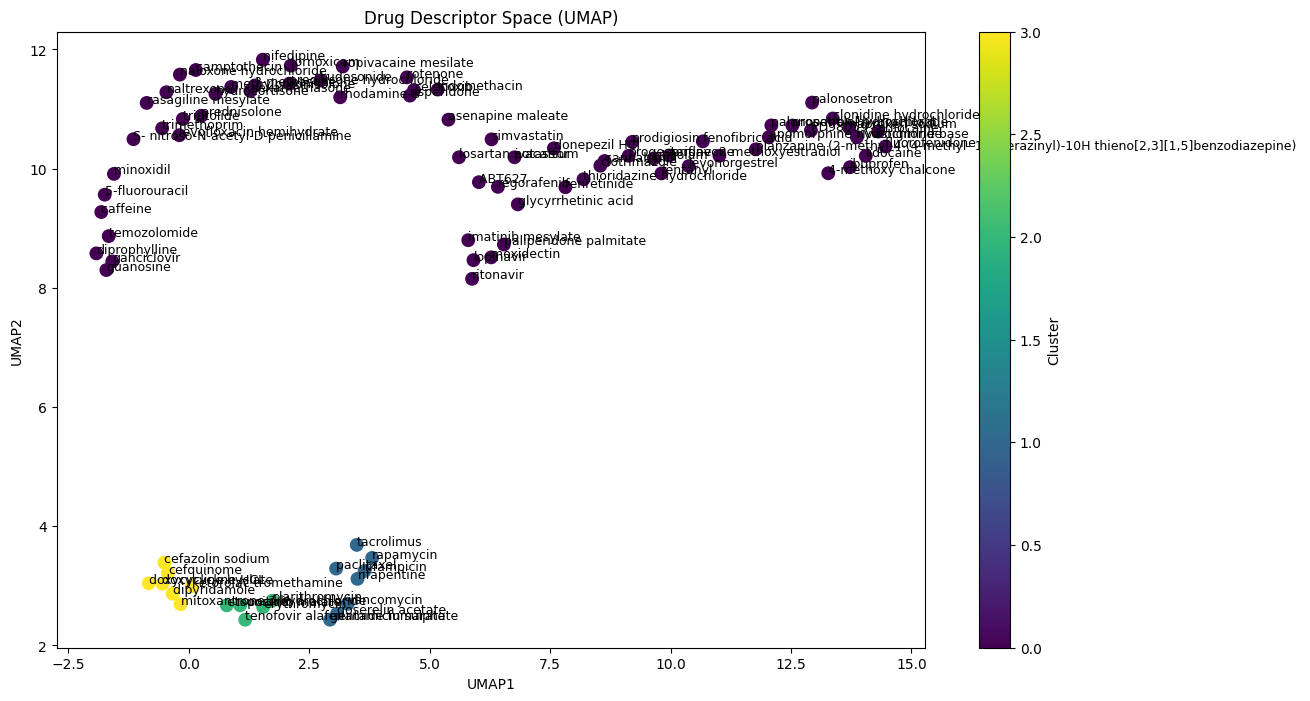

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))

scatter = plt.scatter(
    drug_df["UMAP1"],
    drug_df["UMAP2"],
    c=drug_df["Cluster"],
    cmap="viridis",
    s=80
)

for i, txt in enumerate(drug_df["Drug"]):
    plt.annotate(txt,
                 (drug_df["UMAP1"][i], drug_df["UMAP2"][i]),
                 fontsize=9)

plt.title("Drug Descriptor Space (UMAP)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.colorbar(scatter, label="Cluster")
plt.show()

In [52]:
cluster_names = {
    0: "Small hydrophobic molecules",
    1: "Large hydrophilic molecules",
    2: "Midsized Amphiphilic",
    3: "Hydrophilic drugs"
}

drug_df["Cluster_Label"] = drug_df["Cluster"].map(cluster_names)

drug_df[["Drug", "Cluster", "Cluster_Label"]].head()

,Drug,Cluster,Cluster_Label
0,2-methoxyestradiol,0,Small hydrophobic molecules
1,4-methoxy chalcone,0,Small hydrophobic molecules
2,5-fluorouracil,0,Small hydrophobic molecules
3,?-methasone,0,Small hydrophobic molecules
4,ABT627,0,Small hydrophobic molecules


In [53]:
# Build mapping: Drug → Cluster_Label
drug_to_cluster = drug_df.set_index("Drug")["Cluster_Label"].to_dict()

# Add cluster column to your main dataframe
df_with_descriptors["Cluster_Label"] = df_with_descriptors["Drug"].map(drug_to_cluster)

In [54]:
train_df = df_with_descriptors.iloc[train_idx].copy()

# Keep only rows used in final model
train_df = train_df.loc[X_train_top10.index]

print(train_df[["Drug","Cluster_Label"]].head())

          Drug                Cluster_Label
0  moxidectin   Small hydrophobic molecules
1  moxidectin   Small hydrophobic molecules
2  moxidectin   Small hydrophobic molecules
3  moxidectin   Small hydrophobic molecules
4  moxidectin   Small hydrophobic molecules


Understanding which discriptor is important per cluster

In [55]:
import numpy as np
import pandas as pd
import shap

# 1) Build train_df from original data, then align to X_train_top10 rows
train_df = df_with_descriptors.iloc[train_idx].copy()
train_df = train_df.loc[X_train_top10.index].copy()

# Sanity check
print(train_df[["Drug", "Cluster_Label"]].head())
print("Clusters in train:", train_df["Cluster_Label"].unique())

          Drug                Cluster_Label
0  moxidectin   Small hydrophobic molecules
1  moxidectin   Small hydrophobic molecules
2  moxidectin   Small hydrophobic molecules
3  moxidectin   Small hydrophobic molecules
4  moxidectin   Small hydrophobic molecules
Clusters in train: ['Small hydrophobic molecules' 'Midsized Amphiphilic' 'Hydrophilic drugs'
 'Large hydrophilic molecules']


In [56]:
explainer = shap.TreeExplainer(final_xgb_top10)
shap_exp = explainer(X_train_top10)   # shap.Explanation# Identify time column (if present) and remove it from the SHAP matrix
feature_names = list(shap_exp.feature_names)

time_cols = [c for c in feature_names if "time" in c.lower()]
if len(time_cols) > 0:
    time_col = time_cols[0]
    time_idx = feature_names.index(time_col)

    keep_mask = np.array([i != time_idx for i in range(len(feature_names))])

    shap_values = shap_exp.values[:, keep_mask]
    X_vals = X_train_top10.values[:, keep_mask]
    kept_features = [f for i, f in enumerate(feature_names) if i != time_idx]
else:
    time_col = None
    shap_values = shap_exp.values
    X_vals = X_train_top10.values
    kept_features = feature_names

print("Removed time column:", time_col)
print("Features used for cluster-SHAP:", kept_features)

Removed time column: Time 
Features used for cluster-SHAP: ['Drug Encapsulation Efficiency', 'Drug TPSA', 'Initial Drug-to-Polymer Ratio', 'Particle Size ', 'Drug MW', 'Drug LogP', 'Formulation Method_S/O/W', 'LA/GA', 'Drug Loading Capacity', 'Formulation Method_S/W/O/W']


In [57]:
clusters = pd.Series(train_df["Cluster_Label"].values, index=X_train_top10.index)

cluster_shap = {}

for cl in sorted(clusters.dropna().unique()):
    idx = (clusters == cl).values
    mean_abs = np.abs(shap_values[idx]).mean(axis=0)   # mean |SHAP| for this cluster
    cluster_shap[cl] = mean_abs

shap_cluster_df = pd.DataFrame(cluster_shap, index=kept_features)

# Sort features by overall importance across clusters
shap_cluster_df["Overall_MeanAbsSHAP"] = shap_cluster_df.mean(axis=1)
shap_cluster_df = shap_cluster_df.sort_values("Overall_MeanAbsSHAP", ascending=False).drop(columns=["Overall_MeanAbsSHAP"])

# Display full table
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("\nMean(|SHAP|) per feature per cluster:")
print(shap_cluster_df.to_string())


Mean(|SHAP|) per feature per cluster:
                               Hydrophilic drugs  Large hydrophilic molecules  Midsized Amphiphilic  Small hydrophobic molecules
Drug Encapsulation Efficiency           0.031956                     0.043978              0.039211                     0.037141
Drug MW                                 0.046158                     0.025340              0.022373                     0.030374
Particle Size                           0.017871                     0.028426              0.022526                     0.018698
Drug TPSA                               0.017178                     0.025227              0.020666                     0.012344
Drug Loading Capacity                   0.020378                     0.018856              0.011375                     0.012879
Initial Drug-to-Polymer Ratio           0.009079                     0.010088              0.007804                     0.010771
Drug LogP                               0.011099          

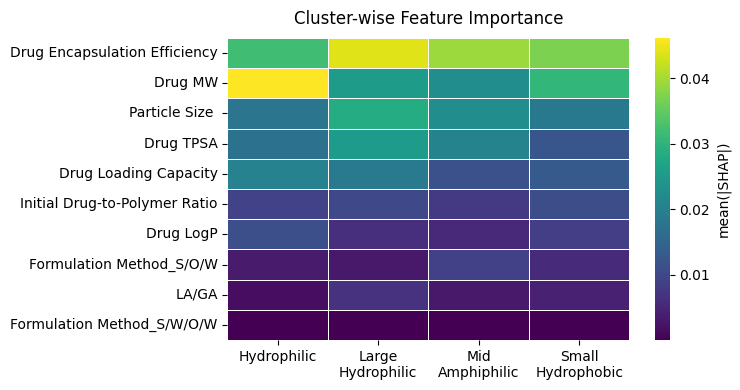

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

short_names = {
    "Small hydrophobic molecules": "Small\nHydrophobic",
    "Large hydrophilic molecules": "Large\nHydrophilic",
    "Midsized Amphiphilic": "Mid\nAmphiphilic",
    "Hydrophilic drugs": "Hydrophilic"
}

plot_df = shap_cluster_df.rename(columns=short_names)

plt.figure(figsize=(7.5, 4))
ax = sns.heatmap(
    plot_df,
    cmap="viridis",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "mean(|SHAP|)"}
)

ax.set_title("Cluster-wise Feature Importance", pad=10)
ax.set_xlabel("")
ax.set_ylabel("")

plt.xticks(rotation=0)      # now it fits
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

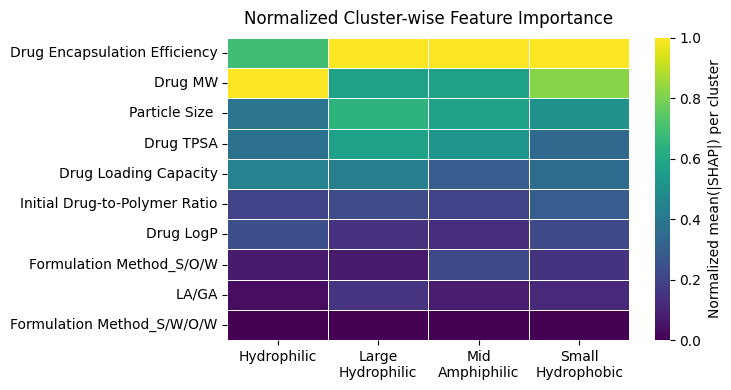

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

short_names = {
    "Small hydrophobic molecules": "Small\nHydrophobic",
    "Large hydrophilic molecules": "Large\nHydrophilic",
    "Midsized Amphiphilic": "Mid\nAmphiphilic",
    "Hydrophilic drugs": "Hydrophilic"
}

plot_df = shap_cluster_df.copy()

# Column-wise normalization (0–1 per cluster)
plot_df = (plot_df - plot_df.min()) / (plot_df.max() - plot_df.min() + 1e-12)
plot_df = plot_df.rename(columns=short_names)

plt.figure(figsize=(7.5, 4))
ax = sns.heatmap(
    plot_df,
    cmap="viridis",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Normalized mean(|SHAP|) per cluster"}
)

ax.set_title("Normalized Cluster-wise Feature Importance", pad=10)
ax.set_xlabel("")
ax.set_ylabel("")

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#VI. BAYESIAN OPTIMIZATION depending on Cluster

In [60]:
import numpy as np
import pandas as pd

# Drug -> Cluster_Label
drug_to_cluster = drug_df.set_index("Drug")["Cluster_Label"].to_dict()
df_with_descriptors["Cluster_Label"] = df_with_descriptors["Drug"].map(drug_to_cluster)

print(df_with_descriptors["Cluster_Label"].value_counts(dropna=False))

Cluster_Label
Small hydrophobic molecules    4082
Large hydrophilic molecules     468
Hydrophilic drugs               228
Midsized Amphiphilic            133
Name: count, dtype: int64


In [61]:
# Define Criteria of Success from literature of drug release. Large hydrophilic drugs allowed higher burst rate due to its nature.
CRITERIA = {
    "Small hydrophobic molecules": {  # cluster 0
        "burst_max": 0.20,
        "total_min": 0.80,
    },
    "Large hydrophilic molecules": {  # cluster 1
        "burst_max": 0.30,
        "total_min": 0.70,
    },
    "Midsized Amphiphilic": {         # cluster 2
        "burst_max": 0.20,
        "total_min": 0.70,
    },
    "Hydrophilic drugs": {            # cluster 3
        "burst_max": 0.20,
        "total_min": 0.70,
    },
}

# Common sustained-release settings
DURATION_START_DAY = 14.0
DURATION_END_DAY   = 30.0
MIN_GAIN_AFTER_14  = 0.10  # at least +10% release after day 14

In [62]:
feature_names = list(X_train_top10.columns)
time_cols = [c for c in feature_names if "time" in c.lower()]
assert len(time_cols) == 1, f"Expected exactly 1 time feature. Found: {time_cols}"
TIME_FEATURE = time_cols[0]
print("Time feature =", TIME_FEATURE)

Time feature = Time 


In [63]:
from pandas.api.types import is_numeric_dtype

# Heuristic: treat these as "drug descriptors" to exclude from optimization
drug_descriptor_like = set([c for c in df_with_descriptors.columns if c.lower().startswith("drug ")])
drug_descriptor_like |= set([c for c in feature_names if c.lower().startswith("drug ")])

# Continuous candidates: numeric model features excluding time and drug descriptors
cont_candidates = []
for c in feature_names:
    if c == TIME_FEATURE:
        continue
    if c in drug_descriptor_like:
        continue
    # try to avoid one-hot method dummies here
    if "formulation method_" in c.lower():
        continue
    # keep numeric
    if c in X_train_top10.columns:
        cont_candidates.append(c)

# Method dummies (optional)
method_dummy_cols = [c for c in feature_names if "formulation method_" in c.lower()]

print("Continuous BO vars (auto):", cont_candidates)
print("Method dummy cols:", method_dummy_cols)

Continuous BO vars (auto): ['Initial Drug-to-Polymer Ratio', 'Particle Size ', 'LA/GA']
Method dummy cols: ['Formulation Method_S/O/W', 'Formulation Method_S/W/O/W']


In [64]:
#Picking representative drugs in each cluster
desc_cols = [c for c in ["Drug LogP", "Drug MW", "Drug TPSA"] if c in drug_df.columns]
assert len(desc_cols) >= 2, f"Need at least 2 drug descriptor columns in drug_df, found: {desc_cols}"

def pick_representative_drug(drug_df, cluster_label):
    sub = drug_df[drug_df["Cluster_Label"] == cluster_label].copy()
    centroid = sub[desc_cols].mean().values
    dists = np.linalg.norm(sub[desc_cols].values - centroid, axis=1)
    return sub.iloc[int(np.argmin(dists))]["Drug"]

clusters = [cl for cl in df_with_descriptors["Cluster_Label"].dropna().unique() if cl in CRITERIA]
rep_drug = {cl: pick_representative_drug(drug_df, cl) for cl in clusters}
rep_drug

{'Small hydrophobic molecules': 'indomethacin',
 'Midsized Amphiphilic': 'etoposide ',
 'Hydrophilic drugs': 'mitoxantrone dihydrochloride ',
 'Large hydrophilic molecules': 'rapamycin'}

In [65]:
# Align training rows to X_train_top10 index (if you use train_idx elsewhere, you can swap here)
train_df_aligned = df_with_descriptors.loc[X_train_top10.index].copy()

def get_cluster_bounds(X, train_df, cluster_label, vars_cont):
    sub_idx = train_df["Cluster_Label"] == cluster_label
    bounds = {}
    for v in vars_cont:
        lo = float(X.loc[sub_idx, v].min())
        hi = float(X.loc[sub_idx, v].max())
        if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
            # fallback: global
            lo = float(X[v].min()); hi = float(X[v].max())
        bounds[v] = (lo, hi)
    return bounds

cluster_bounds = {cl: get_cluster_bounds(X_train_top10, train_df_aligned, cl, cont_candidates) for cl in clusters}
cluster_bounds

{'Small hydrophobic molecules': {'Initial Drug-to-Polymer Ratio': (0.001,
   1.7188765),
  'Particle Size ': (1.5, 295.7),
  'LA/GA': (1.0, 5.67)},
 'Midsized Amphiphilic': {'Initial Drug-to-Polymer Ratio': (0.02, 0.25),
  'Particle Size ': (13.8, 59.5),
  'LA/GA': (1.0, 3.0)},
 'Hydrophilic drugs': {'Initial Drug-to-Polymer Ratio': (0.04, 0.6),
  'Particle Size ': (2.16, 200.0),
  'LA/GA': (1.0, 3.0)},
 'Large hydrophilic molecules': {'Initial Drug-to-Polymer Ratio': (0.0075,
   1.0),
  'Particle Size ': (1.192, 246.37),
  'LA/GA': (1.0, 5.67)}}

In [66]:
def score_curve(pred_curve, times, cluster_label):
    cfg = CRITERIA[cluster_label]

    # Interpolate burst and day14
    r_day1  = float(np.interp(1.0, times, pred_curve))
    r_day14 = float(np.interp(DURATION_START_DAY, times, pred_curve))
    r_final = float(pred_curve[-1])

    loss = 0.0

    # 1) Burst (soft constraint)
    burst_excess = max(0.0, r_day1 - cfg["burst_max"])
    loss += 25.0 * (burst_excess ** 2)

    # Preder ~0.15 for clusters with 0.20 max (<15–20%)
    if cfg["burst_max"] <= 0.20:
        loss += 2.0 * ((r_day1 - 0.15) ** 2)

    # 2) Total release at end
    total_deficit = max(0.0, cfg["total_min"] - r_final)
    loss += 40.0 * (total_deficit ** 2)

    # 3) Monotonicity
    diffs = np.diff(pred_curve)
    neg = diffs[diffs < 0]
    if len(neg):
        loss += 80.0 * float(np.sum(neg**2))

    # 4) Sustained duration proxy: must keep releasing after day 14
    gain_after_14 = r_final - r_day14
    duration_deficit = max(0.0, MIN_GAIN_AFTER_14 - gain_after_14)
    loss += 15.0 * (duration_deficit ** 2)

    return float(loss)

In [67]:
def get_base_row_for_drug(df, drug_name):
    sub = df[df["Drug"] == drug_name]
    assert len(sub) > 0, f"No rows for drug: {drug_name}"
    return sub.iloc[0]

def set_method_dummies(row_dict, method_cols, chosen=None):
    # chosen=None means baseline (all zeros)
    for c in method_cols:
        row_dict[c] = 0.0
    if chosen is not None:
        row_dict[chosen] = 1.0

def predict_curve_xgb(model, base_row, params_cont, times, method_cols=None, method_choice=None):
    rows = []
    for t in times:
        r = {c: 0.0 for c in X_train_top10.columns}

        # Fill any features that exist in the base row (drug descriptors etc.)
        for c in X_train_top10.columns:
            if c in base_row.index:
                val = base_row[c]
                if pd.notnull(val):
                    r[c] = float(val)

        # Apply continuous design knobs
        for k, v in params_cont.items():
            if k in r:
                r[k] = float(v)

        # Apply method (if dummies exist)
        if method_cols and len(method_cols):
            set_method_dummies(r, method_cols, method_choice)

        # Set time feature
        r[TIME_FEATURE] = float(t)

        rows.append(r)

    Xq = pd.DataFrame(rows, columns=X_train_top10.columns)
    preds = model.predict(Xq)
    return np.clip(preds, 0.0, 1.0)

#VI. a. Bayesian Optimization per cluster

In [68]:
!pip -q install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [96]:
import numpy as np

TIMES = np.array([1, 3, 7, 14, 21, 30], dtype=float)

In [97]:
from skopt import gp_minimize
from skopt.space import Real, Categorical
from skopt.utils import use_named_args

In [98]:
def run_bo_for_cluster(cluster_label, n_calls=40, n_init=12, seed=1147):
    # fixed representative drug (keeps drug descriptors constant)
    drug_name = rep_drug[cluster_label]
    base_row = get_base_row_for_drug(df_with_descriptors, drug_name)

    # bounds for continuous knobs in this cluster
    bounds = cluster_bounds[cluster_label]

    # build search space
    space = [Real(bounds[v][0], bounds[v][1], name=v) for v in cont_candidates]

    # categorical choice over method dummies (or None baseline)
    method_choices = [None] + method_dummy_cols
    if len(method_dummy_cols) > 0:
        space.append(Categorical(method_choices, name="MethodDummy"))

    @use_named_args(space)
    def objective(**kwargs):
        params_cont = {v: kwargs[v] for v in cont_candidates}
        method_choice = kwargs.get("MethodDummy", None)

        pred_curve = predict_curve_xgb(
            model=final_xgb_top10,
            base_row=base_row,
            params_cont=params_cont,
            times=TIMES,
            method_cols=method_dummy_cols,
            method_choice=method_choice
        )
        return score_curve(pred_curve, TIMES, cluster_label)

    res = gp_minimize(
        func=objective,
        dimensions=space,
        n_calls=n_calls,
        n_initial_points=n_init,
        random_state=seed,
        acq_func="EI"
    )

    # decode best params
    best = {dim.name: val for dim, val in zip(space, res.x)}
    best_cont = {v: best[v] for v in cont_candidates}
    best_method = best.get("MethodDummy", None)

    # get curve for best
    best_curve = predict_curve_xgb(
        model=final_xgb_top10,
        base_row=base_row,
        params_cont=best_cont,
        times=TIMES,
        method_cols=method_dummy_cols,
        method_choice=best_method
    )

    return {
        "cluster": cluster_label,
        "rep_drug": drug_name,
        "best_loss": float(res.fun),
        "best_cont": best_cont,
        "best_method": best_method,
        "times": TIMES,
        "curve": best_curve,
        "res": res
    }

# Run BO for each cluster
bo_results = []
for cl in clusters:
    print(f"\n=== BO for cluster: {cl} | rep drug: {rep_drug[cl]} ===")
    out = run_bo_for_cluster(cl, n_calls=40, n_init=12, seed=1147)
    bo_results.append(out)
    print("Best loss:", out["best_loss"])
    print("Best continuous params:", out["best_cont"])
    print("Best method:", out["best_method"])


=== BO for cluster: Small hydrophobic molecules | rep drug: indomethacin ===
Best loss: 0.08423821441141066
Best continuous params: {'Initial Drug-to-Polymer Ratio': 0.17802831537117048, 'Particle Size ': 197.3456035155461, 'LA/GA': 5.67}
Best method: Formulation Method_S/W/O/W

=== BO for cluster: Midsized Amphiphilic | rep drug: etoposide  ===
Best loss: 0.00012444328872634376
Best continuous params: {'Initial Drug-to-Polymer Ratio': 0.05957976975442626, 'Particle Size ': 17.96101847130974, 'LA/GA': 1.7618683731688687}
Best method: None

=== BO for cluster: Hydrophilic drugs | rep drug: mitoxantrone dihydrochloride  ===


/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.04, 200.0, 1.0, np.str_('Formulation Method_S/W/O/W')] before, using random point [0.27553500703773404, 188.4637459219839, 2.0845295478177053, 'Formulation Method_S/W/O/W']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.04, 200.0, 1.0, np.str_('Formulation Method_S/W/O/W')] before, using random point [0.4805963998783167, 32.96859850735103, 2.8667168888855477, 'Formulation Method_S/O/W']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.04, 200.0, 1.0, np.str_('Formulation Method_S/W/O/W')] before, using random point [0.27489284684641335, 191.25914915355855, 1.735052033490521, 'Formulation Method_S/W/O/W']
  warnings.warn(
/usr/local/lib/python3.12/dist-packag

Best loss: 0.09125064959283714
Best continuous params: {'Initial Drug-to-Polymer Ratio': 0.04, 'Particle Size ': 137.8158176103178, 'LA/GA': 1.0}
Best method: Formulation Method_S/W/O/W

=== BO for cluster: Large hydrophilic molecules | rep drug: rapamycin ===
Best loss: 0.003704190878352172
Best continuous params: {'Initial Drug-to-Polymer Ratio': 0.5811775362987934, 'Particle Size ': 18.76751668604537, 'LA/GA': 4.258128316520106}
Best method: Formulation Method_S/O/W


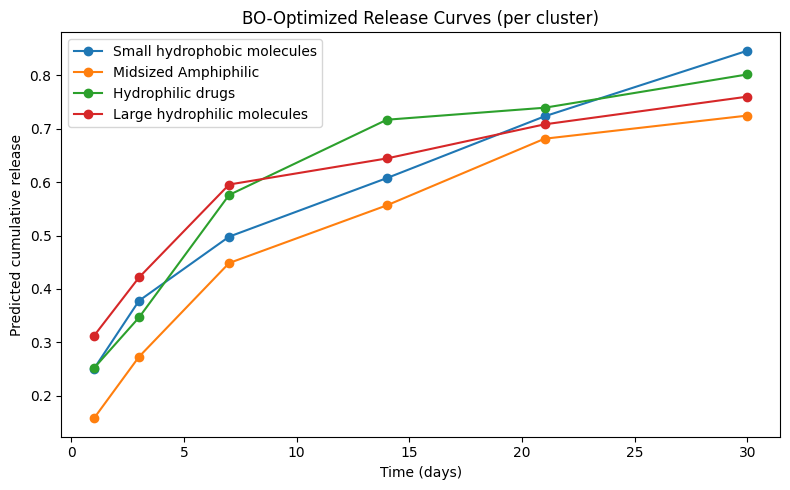

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for r in bo_results:
    plt.plot(r["times"], r["curve"], marker="o", label=r["cluster"])
plt.xlabel("Time (days)")
plt.ylabel("Predicted cumulative release")
plt.title("BO-Optimized Release Curves (per cluster)")
plt.legend()
plt.tight_layout()
plt.show()

#VI.b. Best Curve per cluster and reccomendation

In [100]:
import pandas as pd
import numpy as np

def pretty_method(best_method):
    if best_method is None:
        return "Baseline/unspecified (all method dummies = 0)"
    return best_method.replace("Formulation Method_", "")

rows = []
for r in bo_results:
    cluster = r["cluster"]
    drug    = r["rep_drug"]
    loss    = r["best_loss"]
    params  = r["best_cont"]
    method  = pretty_method(r["best_method"])

    # summarize key predicted outcomes
    curve = np.array(r["curve"], dtype=float)
    times = np.array(r["times"], dtype=float)
    burst_24h = float(np.interp(1.0, times, curve))
    day14     = float(np.interp(14.0, times, curve))
    total     = float(curve[-1])
    tail_gain = total - day14

    rows.append({
        "Cluster": cluster,
        "Rep drug": drug,
        "Best loss": loss,
        "Method": method,
        "Drug:Polymer ratio": params.get("Initial Drug-to-Polymer Ratio", np.nan),
        "Particle size": params.get("Particle Size ", params.get("Particle Size", np.nan)),
        "LA/GA": params.get("LA/GA", np.nan),
        "Pred burst @24h": burst_24h,
        "Pred total @final": total,
        "Pred gain (14d→final)": tail_gain
    })

summary = pd.DataFrame(rows).sort_values("Cluster")
summary

,Cluster,Rep drug,Best loss,Method,Drug:Polymer ratio,Particle size,LA/GA,Pred burst @24h,Pred total @final,Pred gain (14d→final)
2,Hydrophilic drugs,mitoxantrone dihydrochloride,0.091251,S/W/O/W,0.040000,137.815818,1.000000,0.251788,0.801542,0.084767
3,Large hydrophilic molecules,rapamycin,0.003704,S/O/W,0.581178,18.767517,4.258128,0.312172,0.759957,0.115634
1,Midsized Amphiphilic,etoposide,0.000124,Baseline/unspecified (all method dummies = 0),0.059580,17.961018,1.761868,0.157888,0.724515,0.167992
0,Small hydrophobic molecules,indomethacin,0.084238,S/W/O/W,0.178028,197.345604,5.670000,0.250596,0.845934,0.238387


#VII. Compare B.O Reccomendations with Representative drugs from each cluster


In [111]:
import re
import pandas as pd
import numpy as np

# Work on a copy
df_with_descriptors = df_with_descriptors.copy()

# 1) Strip whitespace from ALL column names (this fixes 'Time ' vs 'Time')
df_with_descriptors.columns = [str(c).strip() for c in df_with_descriptors.columns]

print("After strip, columns containing 'time':",
      [c for c in df_with_descriptors.columns if re.search(r"time", c, flags=re.I)])
print("After strip, columns containing 'release':",
      [c for c in df_with_descriptors.columns if re.search(r"release", c, flags=re.I)])

# 2) Auto-detect best Time + Release columns
time_candidates = [c for c in df_with_descriptors.columns if re.search(r"\btime\b", c, flags=re.I)]
rel_candidates  = [c for c in df_with_descriptors.columns if re.search(r"\brelease\b", c, flags=re.I)]

if len(time_candidates) == 0:
    raise ValueError("No time-like column found even after stripping. Print df_with_descriptors.columns to inspect.")
if len(rel_candidates) == 0:
    raise ValueError("No release-like column found even after stripping. Print df_with_descriptors.columns to inspect.")

# Prefer exact matches if present
TIME_COL = "Time" if "Time" in time_candidates else sorted(time_candidates, key=len)[0]
REL_COL  = "Release" if "Release" in rel_candidates else sorted(rel_candidates, key=len)[0]

print("TIME_COL =", TIME_COL)
print("REL_COL  =", REL_COL)

# 3) Rename them to standard names so the rest of your pipeline never breaks again
rename_map = {}
if TIME_COL != "Time":
    rename_map[TIME_COL] = "Time"
if REL_COL != "Release":
    rename_map[REL_COL] = "Release"

if rename_map:
    df_with_descriptors.rename(columns=rename_map, inplace=True)
    print("\nRenamed columns:", rename_map)

print("Has 'Time'?", "Time" in df_with_descriptors.columns)
print("Has 'Release'?", "Release" in df_with_descriptors.columns)

After strip, columns containing 'time': ['Time']
After strip, columns containing 'release': ['Release']
TIME_COL = Time
REL_COL  = Release
Has 'Time'? True
Has 'Release'? True


In [112]:
import numpy as np
import pandas as pd

DRUG_COL = "Drug"
FORM_COL = "Formulation Index"
TIME_COL = "Time"
REL_COL  = "Release"

target_drugs = ["mitoxantrone dihydrochloride", "rapamycin", "etoposide", "indomethacin"]

METHOD_DUMMIES = [c for c in df_with_descriptors.columns if "Formulation Method_" in c]

DESIGN_COLS = [c for c in ["Initial Drug-to-Polymer Ratio", "Particle Size", "Particle Size ", "LA/GA"]
               if c in df_with_descriptors.columns]
print("Detected design columns:", DESIGN_COLS)

def decode_method_from_row(row):
    hits = []
    for c in METHOD_DUMMIES:
        try:
            if float(row.get(c, 0)) == 1.0:
                hits.append(c.replace("Formulation Method_", ""))
        except:
            pass
    return hits[0] if len(hits)==1 else ("Baseline/unspecified" if len(hits)==0 else "+".join(hits))

def burst_and_final(times, release, day=1.0):
    times = np.asarray(times, float)
    release = np.asarray(release, float)
    m = np.isfinite(times) & np.isfinite(release)
    times, release = times[m], release[m]
    if len(times)==0:
        return np.nan, np.nan, np.nan
    o = np.argsort(times)
    times, release = times[o], release[o]
    burst = float(np.interp(day, times, release))
    final = float(release[-1])
    last_t = float(times[-1])
    return burst, final, last_t

df = df_with_descriptors.copy()
df["_drug_lower"] = df[DRUG_COL].astype(str).str.strip().str.lower()
wanted = set([d.lower() for d in target_drugs])
df_sub = df[df["_drug_lower"].isin(wanted)].copy()

print("Rows found:", len(df_sub))
print("Counts:", df_sub[DRUG_COL].value_counts())

summary_rows = []
for (drug, form_id), g in df_sub.groupby([DRUG_COL, FORM_COL], dropna=False):
    method = decode_method_from_row(g.iloc[0])
    design_vals = {c: float(pd.to_numeric(g[c], errors="coerce").dropna().mean()) for c in DESIGN_COLS}
    burst24, final_rel, last_t = burst_and_final(g[TIME_COL], g[REL_COL], day=1.0)

    summary_rows.append({
        "Drug": drug,
        "Formulation Index": form_id,
        "Method": method,
        **design_vals,
        "Actual burst @24h": burst24,
        "Actual final release": final_rel,
        "Last time": last_t,
        "n_points": int(pd.to_numeric(g[TIME_COL], errors="coerce").notna().sum())
    })

summary = pd.DataFrame(summary_rows).sort_values(["Drug","Formulation Index"])
display(summary)

Detected design columns: ['Initial Drug-to-Polymer Ratio', 'Particle Size', 'LA/GA']
Rows found: 79
Counts: Drug
indomethacin                     26
mitoxantrone dihydrochloride     26
rapamycin                        20
etoposide                         7
Name: count, dtype: int64


,Drug,Formulation Index,Method,Initial Drug-to-Polymer Ratio,Particle Size,LA/GA,Actual burst @24h,Actual final release,Last time,n_points
0,etoposide,258,Baseline/unspecified,0.050000,48.150,1.00,0.129970,0.616723,28.082772,7
1,indomethacin,54,Baseline/unspecified,0.250000,60.200,1.00,0.379992,1.008064,30.078947,17
2,indomethacin,266,Baseline/unspecified,0.100000,51.535,1.00,0.063603,0.922222,17.135051,9
3,mitoxantrone dihydrochloride,259,Baseline/unspecified,0.111111,3.800,1.00,0.021637,0.918301,70.296648,13
4,mitoxantrone dihydrochloride,271,Baseline/unspecified,0.111111,7.700,1.00,0.001103,0.910482,91.892444,13
5,rapamycin,35,Baseline/unspecified,0.010000,1.153,1.00,0.256250,0.989388,29.968701,8
6,rapamycin,36,Baseline/unspecified,0.010000,1.192,5.67,0.430990,0.974017,120.000000,12
